In [1]:
# CNN非常善于对图像的特征进行提取，是权值共享的，极大的减少了各层中的参数，从而能够很好的避免反向传播的时候出现梯度消失的现象。
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
print("类型 : ", type(mnist))
print("训练数据个数 ：", mnist.train.num_examples )
print("测试数据个数 ：", mnist.test.num_examples )
print(mnist.train.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.images.shape)
print(mnist.test.labels.shape)

类型 :  <class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
训练数据个数 ： 55000
测试数据个数 ： 10000
(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


In [4]:
learn_rate = 1e-4 # 设置学习率
epoch = 2500 # 迭代次数
dropout = 0.5 # 保留 50% 
batch_size = 50 # 50个图片为一组
image_display = 10 # 每10次迭代显示一次

In [5]:
train_image = mnist.train.images # 每个像素点已经归一化处理好了，并且[0,9]分类结果也已经进行了 one-hot 编码
train_label = mnist.train.labels
print(train_label[1]) # [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]  3
print(train_image[1])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

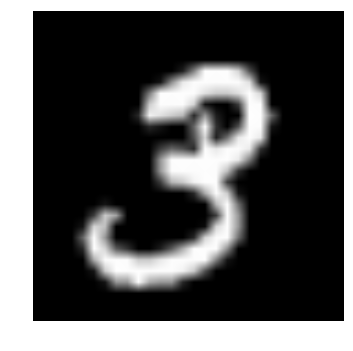

In [6]:
def display(image_width, image_height, img) :
    one_image = img.reshape(image_width, image_height)
    plt.axis('off')
    plt.imshow(one_image, cmap=plt.cm.binary_r)
    plt.show()
display(28, 28, train_image[1])

In [7]:
# 初始化权重
def weight_variable(shape): # 生成卷积核
    # 卷积核，要求也是一个张量，shape为 [ filter_height, filter_weight, in_channel, out_channels ]，
    # 其中 filter_height 为卷积核高度，filter_weight 为卷积核宽度，
    # in_channel 是图像通道数 ，和 input 的 in_channel 要保持一致，out_channel 是卷积核数量。
    stddev=0.1
    initial = tf.truncated_normal(shape=shape, stddev=stddev, seed=6) # stddev : 标准差 
# 产生截断正态分布随机数，取值范围为 [ mean - 2 * stddev, mean + 2 * stddev ]
#     truncated_normal(
#     shape,
#     mean=0.0,
#     stddev=1.0,
#     dtype=tf.float32,
#     seed=None,
#     name=None
# )
    return tf.Variable(initial_value=initial)

# 初始化偏执值
def bias_variable(shape): # 生成偏置项
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


In [8]:
def conv2d(x, W): # 卷积操作 
    return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')
# tf.nn.conv2d (input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)
# input : 输入的要做卷积的图片，要求为一个张量，shape为 [ batch, in_height, in_weight, in_channel ]，其中batch为图片的数量，in_height 为图片高度，in_weight 为图片宽度，in_channel 为图片的通道数，灰度图该值为1，彩色图为3
# filter： 卷积核，要求也是一个张量，shape为 [ filter_height, filter_weight, in_channel, out_channels ]，其中 filter_height 为卷积核高度，filter_weight 为卷积核宽度，in_channel 是图像通道数 ，和 input 的 in_channel 要保持一致，out_channel 是卷积核数量。
# strides： 卷积时在图像每一维的步长，这是一个一维的向量，[ 1, strides, strides, 1]，第一位和最后一位固定必须是1
# padding： string类型，值为“SAME” 和 “VALID”，表示的是卷积的形式，是否考虑边界。"SAME"是考虑边界，不足的时候用0去填充周围，"VALID"则不考虑
# use_cudnn_on_gpu： bool类型，是否使用cudnn加速，默认为true

In [9]:
def max_pool_2x2(x): # 池化操作  作用：1.保留主要的特征,同时减少下一层的参数和计算量，防止过拟合；2. 保持某种不变性，包括translation(平移)，rotation(旋转)，scale(尺度),常用的有mean-pooling和max-pooling。
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
# 第一个参数value：需要池化的输入，一般池化层接在卷积层后面，所以输入通常是feature map，依然是[batch, height, width, channels]这样的shape
# 第二个参数ksize：池化窗口的大小，取一个四维向量，一般是[1, height, width, 1]，因为我们不想在batch和channels上做池化，所以这两个维度设为了1
# 第三个参数strides：和卷积类似，窗口在每一个维度上滑动的步长，一般也是[1, stride,stride, 1]
# 第四个参数padding：和卷积类似，可以取'VALID' 或者'SAME'

In [10]:
# 一般输入都要保证同样大小，使用placehold 相当于形参，格式化输入的数据
image_size = len(train_image[0])
label_size = len(train_label[0])
x = tf.placeholder(dtype='float', shape=[None, image_size])
y_ = tf.placeholder(dtype='float', shape=[None, label_size])

In [11]:
# 第一层卷积
W_conv_1 = weight_variable([5, 5, 1, 32]) # 因为手写体是黑白的，所以只需要设置通道数为 1 即可
b_conv_1 = bias_variable([32])

# (55000, 784) -> (5500, 28, 28, 1)
image_width = 28
image_height = 28
image_channel = 1
image = tf.reshape(x, [-1, image_width, image_height, image_channel])
# print(image.get_shape()) # (?, 28, 28, 1)

#卷积操作
h_conv_1 = tf.nn.relu(conv2d(image, W_conv_1) + b_conv_1)
# print(h_conv_1.get_shape()) # (?, 28, 28, 32)  如果设置padding=VALID 则 (?, 24, 24, 32)
# 宽度/高度 = (输入数据的宽度 + 2 * padding - 卷积核的宽度) / 步长 + 1 # 这里的 1 是最后的一整列

# 池化操作
h_pool_1 = max_pool_2x2(h_conv_1)
# print(h_pool_1.get_shape()) # (?, 14, 14, 32)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# 第二层卷积
W_conv_2 = weight_variable([5, 5, 32, 64]) # 因为经过第一层卷积生成了32张，相当于32个通道,所以只需要设置通道数为 32 即可
b_conv_2 = bias_variable([64])

#卷积操作
h_conv_2 = tf.nn.relu(conv2d(h_pool_1, W_conv_2) + b_conv_2)
# print(h_conv_2.get_shape()) # (?, 28, 28, 32)-> (?, 14, 14, 64)
# 宽度/高度 = (输入数据的宽度 + 2 * padding - 卷积核的宽度) / 步长 + 1 # 这里的 1 是最后的一整列

# 池化操作
h_pool_2 = max_pool_2x2(h_conv_2)
# print(h_pool_2.get_shape()) # (?, 7, 7, 64)  # 由于矩阵大小变小,特征减小,所以通过 张数(通道数) 来增加特征数目

In [13]:
# 第一层全连接层
w_all_con_1 = weight_variable([7 * 7 * 64, 1024]) # 1024是个经验取值
b_all_con_1 = bias_variable([1024])

# (?, 7, 7, 64) -> (?, 7 * 7 * 64) == (?, 3136)
h_pool_2_flat = tf.reshape(h_pool_2, [-1, 7 * 7 * 64])

h_all_con_1 = tf.nn.relu(tf.matmul(h_pool_2_flat, w_all_con_1) + b_all_con_1)
# 加的relu层先当于第二层
# print(h_all_con_1.get_shape()) # (?, 1024)

In [14]:
# dropout 防止过拟合,一般加在最后一层
keep_prob = tf.placeholder('float')
h_all_con_drop = tf.nn.dropout(h_all_con_1, keep_prob=keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
# 第二层全连接层
w_all_con_2 = weight_variable([1024, label_size])
b_all_con_2 = bias_variable([label_size])

y = tf.nn.softmax(tf.matmul(h_all_con_drop, w_all_con_2) + b_all_con_2)
# print(y.get_shape()) # (?, 10)

In [16]:
cross_entropy = -tf.reduce_sum(y_ * tf.log(y)) # 计算交叉熵
train_step = tf.train.GradientDescentOptimizer(learning_rate=learn_rate).minimize(cross_entropy)

correct_predictioin = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean( tf.cast(correct_predictioin, 'float') )

In [17]:
import numpy as np

In [18]:
epochs_completed = 0
examples_num = train_image.shape[0]
# print(num_examples) # 55000

def next_batch(s):
    
    global train_image
    global train_label
    global index_in_epoch
    global epochs_completed
    
    start = s * batch_size
    end = start + batch_size
    
    if end > examples_num : 
        epochs_completed += 1
        perm = np.arange(examples_num)
        np.random.shuffle(perm)
        train_image = train_image[perm]
        train_label = train_label[perm]
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
        
    return train_image[start:end], train_label[start:end]


In [19]:
# 初始化
init_op = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init_op)

In [20]:
# 统计数据
train_accuracies = []
test_accuracies = []
x_range = []

display_step = 1

for i in range(50) :
    
    tot_batch = int(examples_num / batch_size)
    for j in range(tot_batch - 1000) :
        
        # 拿到一个batch
#         print(j)
        batch_x,batch_y = next_batch(j)
#         print(batch_x.shape)
        sess.run(train_step, feed_dict={x:batch_x, y_:batch_y, keep_prob:[1.0]})
    
    if i % display_step == 0 :
        print("第"+ str(i) +"轮 "  )
        feeds = {x : mnist.train.images[:100], y_ : mnist.train.labels[:100], keep_prob:1.0}
        train_acc = sess.run(accuracy, feed_dict=feeds)
        feeds = {x : mnist.test.images[:100], y_ : mnist.test.labels[:100], keep_prob:1.0}
        test_acc = sess.run(accuracy, feed_dict=feeds)
        print("训练集得分：" + str(train_acc) + "  " + "测试集得分：" + str(test_acc))


第0轮 
训练集得分：0.89  测试集得分：0.86
第1轮 
训练集得分：0.93  测试集得分：0.92
第2轮 
训练集得分：0.94  测试集得分：0.94
第3轮 
训练集得分：0.95  测试集得分：0.96
第4轮 
训练集得分：0.96  测试集得分：0.96
第5轮 
训练集得分：0.96  测试集得分：0.97
第6轮 
训练集得分：0.97  测试集得分：0.96
第7轮 
训练集得分：0.98  测试集得分：0.96
第8轮 
训练集得分：0.98  测试集得分：0.96
第9轮 
训练集得分：0.98  测试集得分：0.96
第10轮 
训练集得分：0.98  测试集得分：0.96
第11轮 
训练集得分：0.99  测试集得分：0.96
第12轮 
训练集得分：0.99  测试集得分：0.96
第13轮 
训练集得分：0.99  测试集得分：0.96
第14轮 
训练集得分：1.0  测试集得分：0.96
第15轮 
训练集得分：1.0  测试集得分：0.96
第16轮 
训练集得分：1.0  测试集得分：0.96
第17轮 
训练集得分：1.0  测试集得分：0.96
第18轮 
训练集得分：1.0  测试集得分：0.96
第19轮 
训练集得分：1.0  测试集得分：0.96
第20轮 
训练集得分：1.0  测试集得分：0.96
第21轮 
训练集得分：1.0  测试集得分：0.96
第22轮 
训练集得分：1.0  测试集得分：0.96
第23轮 
训练集得分：1.0  测试集得分：0.96
第24轮 
训练集得分：1.0  测试集得分：0.96
第25轮 
训练集得分：1.0  测试集得分：0.96
第26轮 
训练集得分：1.0  测试集得分：0.96
第27轮 
训练集得分：1.0  测试集得分：0.97
第28轮 
训练集得分：1.0  测试集得分：0.97
第29轮 
训练集得分：1.0  测试集得分：0.97
第30轮 
训练集得分：1.0  测试集得分：0.97
第31轮 
训练集得分：1.0  测试集得分：0.97
第32轮 
训练集得分：1.0  测试集得分：0.97
第33轮 
训练集得分：1.0  测试集得分：0.97
第34轮 
训练集得分：1.0  测试集得分：0.97
第35轮 
训练集得分：1.0 